In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import matplotlib
import cartopy.crs as ccrs # Projections
import cartopy.feature as cfeature
import cartopy
import datetime

In [2]:
sentinel_data_A = pd.read_csv("data/Sentinel_3A_water_level_Version0.csv")
sentinel_data_A = sentinel_data_A.rename(
    columns={
        "Date (YYYYMMDD)" : "date",
        "Lake_name" : "lake_name",
        "Latitude" : "latitude",
        "Longitude" : "longitude",
        "Relaive_orbit" : "relative_orbit",
        "Lake water level (m)" : "lake_water_level"
    }
)

###### Isolate Lake Winnipeg data

In [3]:
lake_winnipeg = sentinel_data_A[
    sentinel_data_A["lake_name"] == "Winnipeg"
]

In [4]:
pd.unique(lake_winnipeg[
    lake_winnipeg["relative_orbit"] == pd.unique(lake_winnipeg["relative_orbit"])[0]
]["date"])

array([20160401, 20160428, 20160525, 20160621, 20160718, 20160814,
       20160910, 20161007, 20161103, 20161130, 20161227, 20170123,
       20170219, 20170318, 20170414, 20170511, 20170607, 20170704,
       20170731, 20170827, 20170923, 20171020, 20171116, 20171213,
       20180109, 20180205, 20180304, 20180331, 20180427, 20180620,
       20180717, 20180813, 20180909, 20181006, 20181102, 20181129,
       20181226, 20190122, 20190218, 20190317, 20190510, 20190606,
       20190703, 20190730, 20190826, 20210604, 20210701, 20210728,
       20210824, 20210920])

## Plot ground track along Lake Winnipeg

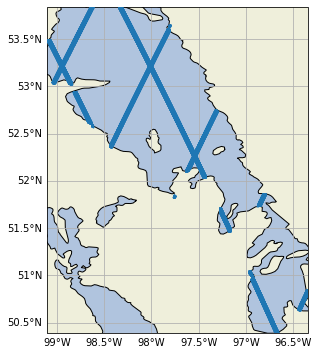

In [5]:
# Get the extent from the data
extent = [
    lake_winnipeg["longitude"].min(),
    lake_winnipeg["longitude"].max(),
    lake_winnipeg["latitude"].min(),
    lake_winnipeg["latitude"].max(),
]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# High resolution lakes
lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m')

# Land, river, and lakes
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(lakes_50m, facecolor='lightsteelblue',edgecolor='black')

# Plot altimetry points
ax.scatter(
    x=np.array(lake_winnipeg["longitude"]),
    y=np.array(lake_winnipeg["latitude"]),
    zorder=10,
    s=1
)

# Format gridlines
# https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/gridliner.html
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

## Explore Outliers

### Distribution of Water Levels... ignore $\mu\pm2\sigma$?
I sketch the idea below, but I'm not sure it's a good idea to actually implement

In [6]:
lake_water_mean = lake_winnipeg["lake_water_level"].mean()
lake_water_std = lake_winnipeg["lake_water_level"].std()
print(f"The mean lakewater level is {lake_water_mean:0.2f}m and the standard deviation is {lake_water_std:0.2f}m")

The mean lakewater level is 217.27m and the standard deviation is 1.16m


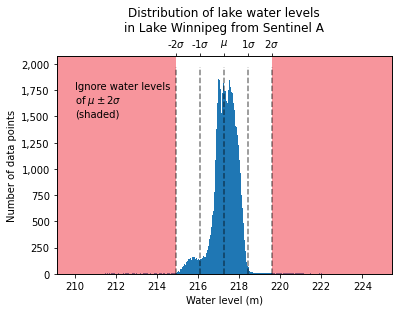

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(
    x=lake_winnipeg["lake_water_level"],
    bins=np.linspace(
        lake_water_mean - 5 * lake_water_std,
        lake_water_mean + 5 * lake_water_std,
        500
    )
)
ax.set_xlim(
    [
        lake_water_mean - 7 * lake_water_std,
        lake_water_mean + 7 * lake_water_std,
    ]
)

ax.axvspan(
    xmin=ax.get_xlim()[0],
    xmax=lake_water_mean - 2 * lake_water_std,
    facecolor="#F02D3A",
    alpha=0.5
)
ax.axvspan(
    xmin=lake_water_mean + 2 * lake_water_std,
    xmax=ax.get_xlim()[1],
    facecolor="#F02D3A",
    alpha=0.5
)


vline_water_levels = [lake_water_mean + i * lake_water_std for i in range(-2,3)]
ax.vlines(
    x=vline_water_levels,
    ymin=ax.get_ylim()[0],
    ymax=ax.get_ylim()[1],
    color='k',
    linestyle='--',
    alpha=0.5
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_xlabel("Water level (m)")
ax.set_ylabel("Number of data points")

ax1 = ax.twiny()
ax1.set_xlim(
    ax.get_xlim()
)
ax1.set_xticks(
    [lake_water_mean + i * lake_water_std for i in range(-2, 3)]
)
ax1.set_xticklabels(
    [
        r'-2$\sigma$',
        r'-1$\sigma$',
        r'$\mu$',
        r'1$\sigma$',
        r'2$\sigma$',
    ]
)

ax.text(210, 1500, 'Ignore water levels\n' + r'of $\mu  \pm2\sigma$' + '\n(shaded)')
plt.title("Distribution of lake water levels\nin Lake Winnipeg from Sentinel A")
plt.show()

### Water levels in different times of year.
There is ice cover in winter. Take summary stats of winter and non-winter and see how different they are.
I'm not sure this is particularly informative.

In [8]:
lake_winnipeg.head()

,date,lake_name,latitude,longitude,relative_orbit,lake_water_level
228868,20160401,Winnipeg,51.860057,-96.819518,283,217.4011
228869,20160401,Winnipeg,51.857120,-96.820913,283,217.5197
228870,20160401,Winnipeg,51.854183,-96.822309,283,217.2064
228871,20160401,Winnipeg,51.851245,-96.823704,283,217.3213
228872,20160401,Winnipeg,51.848308,-96.825099,283,217.3166


In [9]:
def add_winter_column(lake_winnipeg):
    # Add a column to indicate if the date is in winter or not.
    lake_winnipeg.loc[:, "date_as_datetime"] = pd.to_datetime(lake_winnipeg.loc[:, "date"], format="%Y%m%d")
    lake_winnipeg.loc[:, "month"] = lake_winnipeg["date_as_datetime"].apply( lambda x: x.month)
    lake_winnipeg.loc[:, "day"] = lake_winnipeg["date_as_datetime"].apply( lambda x: x.day)
    lake_winnipeg.loc[:, "winter"] = ((lake_winnipeg["month"] < 4) | (lake_winnipeg["month"] > 10))
    return lake_winnipeg

def remove_winter_column(lake_winnipeg):
    lake_winnipeg = lake_winnipeg.drop(columns=["winter", "month", "day", "date_as_datetime"])
    return lake_winnipeg

In [10]:
lake_winnipeg = add_winter_column(lake_winnipeg)

/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93713/2287572897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg.loc[:, "date_as_datetime"] = pd.to_datetime(lake_winnipeg.loc[:, "date"], format="%Y%m%d")
/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93713/2287572897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg.loc[:, "month"] = lake_winnipeg["date_as_datetime"].apply( lambda x: x.month)
/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_

The mean lake water level in winter (Nov - March) is 216.97m.
The mean lake water level in non-winter (Apr - Oct) is 217.41m.

In [11]:
lake_winnipeg.loc[
    lake_winnipeg["winter"] == True,
    "lake_water_level"
].describe()

count    35584.000000
mean       216.977128
std          1.037623
min        187.942875
25%        216.655480
50%        217.051439
75%        217.488527
max        227.617834
Name: lake_water_level, dtype: float64

In [12]:
lake_winnipeg.loc[
    lake_winnipeg["winter"] == False,
    "lake_water_level"
].describe()

count    72920.000000
mean       217.409069
std          1.196905
min        183.408658
25%        217.159186
50%        217.483098
75%        217.780306
max        235.595841
Name: lake_water_level, dtype: float64

In [13]:
#lake_winnipeg = remove_winter_column(lake_winnipeg)

## Errors and Outliers
### Error: Calculate Absolute Deviance from the Mean (ADM)
Take the median along each track, and then subtract it from all the measurements. Most measurements have an error well below 0.25 m. See the DAHITI paper for more details.

Every day in the data represents a different track. (See the bottom of this workbook for a map that shows different tracks on different days.)

##### ADM = "Absolute deviation around the median"
###### (see https://hess.copernicus.org/articles/19/4345/2015/hess-19-4345-2015.pdf)

In [14]:
def add_adm_error(lake_winnipeg):
    lake_winnipeg["error"] = 0
    unique_dates = pd.unique(lake_winnipeg["date"])
    for date in unique_dates:
        median_water_level = lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].median()
        lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "error"
        ] = lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].apply(lambda x: np.abs(x - median_water_level) + 0.25)
    return lake_winnipeg

def remove_adm_error(lake_winnipeg):
    lake_winnipeg = lake_winnipeg.drop(columns=["error"])
    return lake_winnipeg

In [15]:
lake_winnipeg = add_adm_error(lake_winnipeg)

/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93713/1372700968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg["error"] = 0
/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93713/1372700968.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg.loc[


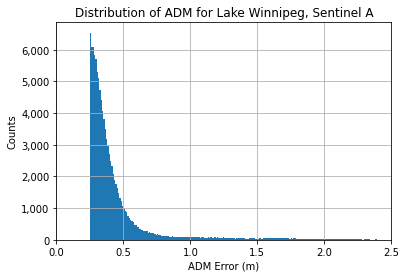

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(
    lake_winnipeg["error"],
    bins=np.linspace(0, 5, 501)
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_xlabel("ADM Error (m)")
ax.set_ylabel("Counts")
ax.grid(True)
ax.set_xlim([0, 2.5])
plt.title("Distribution of ADM for Lake Winnipeg, Sentinel A")
plt.show()

### Outliers: Reject $\pm2\sigma$
For each track, take the mean and reject points that are more than $\mu\pm3\sigma$ from the mean.

In [17]:
lake_winnipeg["mean_track_lake_water_level"] = lake_winnipeg.groupby("date")["lake_water_level"].transform("mean")
lake_winnipeg["std_track_lake_water_level"] = lake_winnipeg.groupby("date")["lake_water_level"].transform("std")
number_of_standard_deviations = 2 # Reject points that are more than number_of_standard_deviation*std from the mean

/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93713/3229246027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg["mean_track_lake_water_level"] = lake_winnipeg.groupby("date")["lake_water_level"].transform("mean")
/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93713/3229246027.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg["std_track_lake_water_level"] = lake_winnipeg.groupby("date")["lake_water_level"].transform("std")


In [18]:
lake_winnipeg["reject"] = lake_winnipeg.apply(
    lambda row: True if np.abs(
        row["lake_water_level"] - row["mean_track_lake_water_level"]
    ) > number_of_standard_deviations*row["std_track_lake_water_level"] else False,
    axis=1
)

/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_93713/3296338023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg["reject"] = lake_winnipeg.apply(


In [19]:
lake_winnipeg.loc[
    lake_winnipeg["reject"] == False
].head()

,date,lake_name,latitude,longitude,relative_orbit,lake_water_level,date_as_datetime,month,day,winter,error,mean_track_lake_water_level,std_track_lake_water_level,reject
228868,20160401,Winnipeg,51.860057,-96.819518,283,217.4011,2016-04-01,4,1,False,0.29045,217.365902,0.078854,False
228869,20160401,Winnipeg,51.857120,-96.820913,283,217.5197,2016-04-01,4,1,False,0.40905,217.365902,0.078854,False
228871,20160401,Winnipeg,51.851245,-96.823704,283,217.3213,2016-04-01,4,1,False,0.28935,217.365902,0.078854,False
228872,20160401,Winnipeg,51.848308,-96.825099,283,217.3166,2016-04-01,4,1,False,0.29405,217.365902,0.078854,False
228873,20160401,Winnipeg,51.845371,-96.826494,283,217.3736,2016-04-01,4,1,False,0.26295,217.365902,0.078854,False


In [34]:
# Write the processed data frame to file, for the purposes of reusing for Kalman filtering and making figures
lake_winnipeg.to_csv("./processed/sentinel_a_lake_winnipeg_remove_outliers.csv", index=False)

# Kalman Filtering

Work on one time step and then put a loop over time steps. The KalmanNet paper equations are written differently than the DAHITI paper, but are equivalent. We take hints from DAHITI, since they solve the lake water level problem using Kalman filtering.

### Model:
#### State variable (i.e. lake water levels)

$\mathbf{x}_{t|t-1} = \mathbf{F} \mathbf{x}_{t-1|t-1}$

- $\mathbf{x}$ is the state variable, but essentially represents the lake water level. It is a scalar (just a number)
- $\mathbf{x}_{t|t-1}$ is the prior at time $t$ and $\mathbf{x}_{t|t}$ is the posterior. It is a scalar (just a number). In code, the prior is `x_t_prior` and the posterior is `x_t`
- $\mathbf{F}$ is identity matrix (see equation (4) in DAHITI). Since everything in this equation is a scalar, $\mathbf{F}$ is just a single 1.

$\mathbf{\Sigma}_{t|t-1} = \mathbf{F} \mathbf{\Sigma}_{t-1|t-1} \mathbf{F}^T + \mathbf{Q}$

- $\mathbf{\Sigma}_{t|t-1}$ is the a priori estimate for the error in the state variable at time $t$, and $\mathbf{\Sigma}_{t|t}$ is the posterior. It is a scalar. In code, these are `sigma_t_prior` and `sigma_t`
- $\mathbf{Q}$ is the covariance matrix for the model noise. In this case, it is a scalar.

#### "Observations"
Note that $\mathbf{y}_t$ are the actual lake water observations at time $t$, but $\mathbf{y}_{t|t-1}$ are not; the latter are the prior estimates for the lake water level at time $t$.

$\mathbf{y}_{t|t-1} = \mathbf{H} \mathbf{x}_{t|t-1}$

- $\mathbf{y}_{t|t-1}$ is the prior estimate for all the lake water level measurements at time $t$.
- $\mathbf{H}$ is a column vector of 1's. There are as many ones are there are data points at time $t$. In code, we call this the model matrix because it "models" the state variable into a "guess" for the observations.

$\mathbf{S}_{t|t-1} = \mathbf{H} \mathbf{\Sigma}_{t|t-1} \mathbf{H}^T + \mathbf{R}$
- $\mathbf{S}_{t|t-1}$ is the prior estimate for the error in the observations. Its dimension is $m_t \times m_t$ where $m_t$ is the number of data points at time $t$.
- $\mathbf{R}$ is the covariance matrix for the observation noise. To get it, you take the ADM error for each data point (at the time step) and place the errors along the diagonal. (See equation (3) in the DAHITI paper. Their $\Sigma_{ll,k}$ is our $\mathbf{R}$.) $\mathbf{R}$ is $m_t \times m_t$

#### Kalman Gain
The Kalman Gain is calculated as

$\mathbf{K_t} = \mathbf{\Sigma}_{t|t-1} \mathbf{H}^T \mathbf{S}_{t|t-1}^{-1}$

In code this is `K_t`.

### Process
1. Initialize the Kalman Filter on the first time step. Start by setting the prior estimate for the state variable to the lake water level on the first day with the lowest error. Set the prior estimate for the model noise to 1. Then input the data for the first time point, and define the model matrix, the covariance matrix for the observations, the prior estimate for the error in the observations, and the prior estimates for the lake levels. We also input the observations at the time step (See `y_t` in input_new_data()).

2. Update the Kalman filter. Calculate the Kalman gain and get the posterior state variable estimate `x_t`, which is our lake water estimates, and the posterior estimate for the error in the measurements `sigma_t`.

3. Predict the next priors. Set the posterior of the current time step to the prior of the next time step.

### Other notes
An open question is how should ADM be calculated. Above, in code, (see the `apply` statement in cell 15) we've added a bulk error to the ADM. What should this number be?

How should we esimate $\mathbf{Q}_t$? Can we take hints from the DAHITI paper?

In [35]:
class KalmanFilter:
    def __init__(self):
        self.m_t = 0 # number of points in this time step
        self.x_t_prior = 0 # x_t prior, scalar
        self.x_t = 0 # x_t update, scalar
        self.F_t = 0 # transition matrix, scalar
        self.H_t = 0 # model matrix (m_t, 1)
        self.sigma_t_prior = 0 # model noise, prior; scalar
        self.S_t_prior = 0 # observation noise, prior; (m_t, m_t)
        self.sigma_t = 0 # model noise, update; scalar
        self.S_t = 0 # observation noise, update; (m_t, m_t)
        self.y_t_prior = 0 # predictions for observations based on x_t_prior
        self.y_t = 0 # observations; (m_t, 1)
        self.K_t = 0 # Kalman gain
        self.R_t = 0 # Covariance of noise in the observations at time t
        self.Q_t = 0 # Covariance of the model noise
        
    def initialize(self, lake_data_0):
        # lake_data_0 is the lake data for the zeroth time step.
        # In our Lake Winnipeg case, it will be something like this;
        # lake_data_0 = lake_winnipeg.loc[
        #    lake_winnipeg["date"] = pd.unique(lake_winnipeg["date"])[0]
        #]
        
        # Initialize the x_t_prior to the lake water level that has the lowest
        # error estimate
        water_level_with_smallest_error = lake_data_0.loc[
            lake_data_0['error'].idxmin()
        ]['lake_water_level']
        self.x_t_prior = water_level_with_smallest_error
        
        # Initialize the model noise to unity
        self.sigma_t_prior = 1.
        
        # Define the variables from the data
        self.input_new_data(lake_data_0)
        
        # Set the transition "matrix"
        self.F_t = 1
        
        # Set the...?
        self.Q_t = 0.05**2
        
    def input_new_data(self, lake_data):
        # Set the number of points in this time step
        self.m_t = len(lake_data)
        
        # Set the model matrix
        self.H_t = np.ones((self.m_t, 1))
        
        # Set the observation noise matrix.
        self.R_t = np.zeros((self.m_t, self.m_t))
        np.fill_diagonal(self.R_t, lake_data["error"])
        self.S_t_prior = self.R_t + np.matmul(self.H_t, np.transpose(self.H_t)) * self.sigma_t_prior
        
        # Initialize the observations
        self.y_t = np.array(lake_data["lake_water_level"]).reshape(self.m_t, 1)
        
        # Initialize the estimates based on the priors
        self.y_t_prior = self.H_t  * self.x_t_prior
    
    def calculate_kalman_gain(
        self,
        sigma_t_prior, # model noise, prior
        S_t_prior, # Observation noise, prior
        H_t, # model matrix
    ):
        return np.matmul(
            sigma_t_prior * np.transpose(H_t),
            np.linalg.pinv(S_t_prior)
        )
        
    def update(self):
        self.K_t = self.calculate_kalman_gain(
            self.sigma_t_prior,
            self.S_t_prior,
            self.H_t
        )
        
        # Update state variable
        self.x_t = self.x_t_prior + np.matmul(
            self.K_t,
            self.y_t - self.y_t_prior
        ).item()

        # Update sigma_t
        self.sigma_t = self.sigma_t_prior - np.matmul(
            self.K_t,
            np.matmul(
                self.S_t_prior,
                np.transpose(self.K_t)
            )
        ).item()
    
    def predict(self): # Is a better name predict_next_prior?
        self.x_t_prior = self.x_t
        self.sigma_t_prior = self.sigma_t + self.Q_t

In [36]:
# Select data from lake_winnipeg that lies within 2*sigma of the mean
lake_winnipeg_filtered = lake_winnipeg.loc[
    lake_winnipeg["reject"] == False
]

In [37]:
times = pd.unique(lake_winnipeg_filtered["date"])
lake_water_levels = np.zeros(np.array(times).shape)
oHai = KalmanFilter()
number_of_time_points = len(times)

for i, time in enumerate(times):
    # Initialize
    if i == 0:
        oHai.initialize(
            lake_winnipeg_filtered.loc[
                lake_winnipeg_filtered["date"] == time
            ]
        )
    else:
        oHai.input_new_data(
            lake_winnipeg_filtered.loc[
                lake_winnipeg_filtered["date"] == time
            ]
        )
     # Update
    oHai.update()
    
#     # Get the lake water levels
    lake_water_levels[i] = oHai.x_t # This should be a variable like y_k which is just x_k?
    
    oHai.predict()
    
    if (i%100 == 0) or (i == number_of_time_points - 1):
        percentage_complete = i/(number_of_time_points - 1) * 100.
        print("Processing %d, %0.02f%% complete"%(time, percentage_complete))

Processing 20160401, 0.00% complete
Processing 20170418, 29.50% complete
Processing 20180612, 59.00% complete
Processing 20190729, 88.50% complete
Processing 20210924, 100.00% complete


In [38]:
# Form a baseline comparison; take the median on each day, and calculate rms error

def rms(values):
    return np.sqrt(sum(values**2)/len(values))

baseline_results = lake_winnipeg_filtered[
    [
        "date",
        "lake_water_level"
    ]
].groupby("date").agg(
    {
        "lake_water_level" : "median"
    }
).reset_index()

baseline_results.loc[:, "date_as_datetime"] = pd.to_datetime(baseline_results.loc[:, "date"], format="%Y%m%d")

In [39]:
baseline_results

,date,lake_water_level,date_as_datetime
0,20160401,217.357400,2016-04-01
1,20160404,217.420749,2016-04-04
2,20160405,217.431191,2016-04-05
3,20160416,217.734666,2016-04-16
4,20160420,217.687387,2016-04-20
...,...,...,...
335,20210916,216.917040,2021-09-16
336,20210919,216.990866,2021-09-19
337,20210920,216.948550,2021-09-20
338,20210923,216.848682,2021-09-23


In [40]:
time_as_datetime = pd.to_datetime(times, format="%Y%m%d")

In [41]:
# Write the results for Kalman filtering to file so we can make figures later on
# without having to re-process all the data
kalman_filtered = pd.DataFrame(
    {
        "date" : np.array(times),
        "kalman_filtered_lake_water_levels" : lake_water_levels
    }
)
kalman_filtered.to_csv("./processed/sentinel_a_lake_winnipeg_kalman_filtered.csv", index=False)

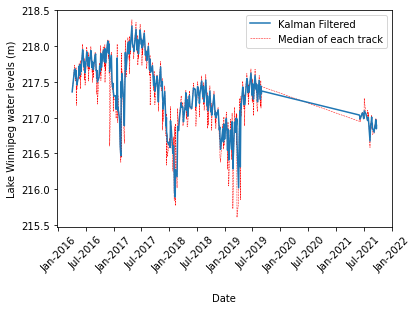

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time_as_datetime, lake_water_levels, zorder=10, label="Kalman Filtered")
ax.plot(
    baseline_results["date_as_datetime"],
    baseline_results["lake_water_level"],
    'r--',
    linewidth=0.5,
    label="Median of each track"
)
ax.set_xlabel('Date', labelpad=20)
ax.set_ylabel('Lake Winnipeg water levels (m)')

# Set labels to be every six months
locator = matplotlib.dates.MonthLocator((1, 7))
fmt = matplotlib.dates.DateFormatter('%b-%Y')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)
for x in ax.get_xticklabels():
    x.set_rotation(45)

ax.legend()
plt.show()

##### Zoom in

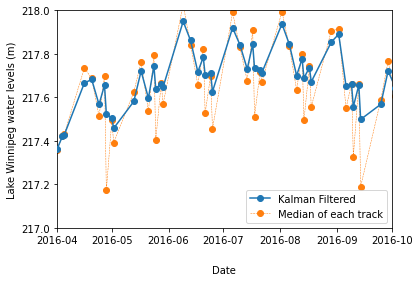

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time_as_datetime, lake_water_levels, '-o', zorder=10, label="Kalman Filtered")
ax.plot(
    baseline_results["date_as_datetime"],
    baseline_results["lake_water_level"],
    '--o',
    linewidth=0.5,
    label="Median of each track"
)
ax.set_xlabel('Date', labelpad=20)
ax.set_ylabel('Lake Winnipeg water levels (m)')

ax.legend()
plt.xlim(datetime.datetime(month=4, day=1, year=2016), datetime.datetime(month=10, day=1, year=2016))
plt.ylim(217, 218)
plt.show()

# Other ideas
### Outliers: Apply Linear SV regression (did not end up panning out)
Along a track of data, apply a linear (flat) SV regression. This gives "wide margin" regression. DAHITI suggests to ignore points that sit outside the margins of +/- 5cm. Perhaps we can be more generous to 25 cm?

Plot the water levels against the longitude coordinate. It seems we can get away with this, since none of our tracks are vertical (i.e. at const longitude)

In [44]:
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression

In [45]:
# Illustrate for one date
date = pd.unique(lake_winnipeg["date"])[5]
X = np.array(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ]
).reshape(-1, 1)
y = np.array(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "lake_water_level"
    ]
).ravel()
lin_reg = LinearRegression()
lin_reg.fit(X, y)
# svm_reg = LinearSVR(epsilon=0.05, max_iter=1000, C=1e6)
# svm_reg.fit(X, y)

LinearRegression()

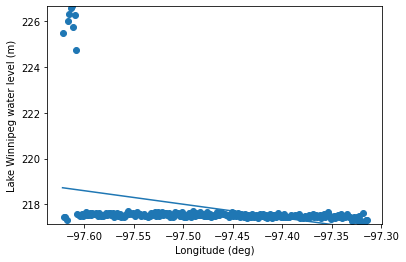

In [46]:
fig = plt.figure()

# Set x-range (i.e. longitude range)
longitude_range = np.linspace(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ].min(),
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ].max(),
    100
)

# water_levels_predicted = svm_reg.predict(longitude_range.reshape(100, 1))
water_levels_predicted = lin_reg.predict(longitude_range.reshape(100, 1))

ax = fig.add_subplot(111)
ax.plot(longitude_range, water_levels_predicted)
# ax.plot(longitude_range, water_levels_predicted - svm_reg.epsilon, "k--")
# ax.plot(longitude_range, water_levels_predicted + svm_reg.epsilon, "k--")
ax.scatter(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ],
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "lake_water_level"
    ]
)
ax.set_ylim(
    [
        lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].min(),
        lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].max(),
    ]
)
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Lake Winnipeg water level (m)")
plt.show()

### Every day is a different track

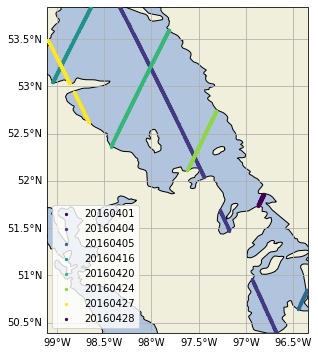

In [47]:
# Change this parameter
number_of_tracks = 8

# Make the cartopy map the background
extent = [
    lake_winnipeg["longitude"].min(),
    lake_winnipeg["longitude"].max(),
    lake_winnipeg["latitude"].min(),
    lake_winnipeg["latitude"].max(),
]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m')
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(lakes_50m, facecolor='lightsteelblue',edgecolor='black')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Plot altimetry points
number_of_colours = 7
cmap = matplotlib.cm.get_cmap('viridis')
colours = cmap(np.linspace(0, 1, number_of_colours))
for i, date in enumerate(pd.unique(lake_winnipeg["date"])[0:number_of_tracks]):
    ax.scatter(
        x=lake_winnipeg.loc[
            lake_winnipeg["date_as_datetime"] == pd.to_datetime(date, format="%Y%m%d"),
            "longitude"
        ],
        y=lake_winnipeg.loc[
            lake_winnipeg["date_as_datetime"] == pd.to_datetime(date, format="%Y%m%d"),
            "latitude"
        ],
        s=5,
        color=colours[i%number_of_colours],
        label=date,
        zorder=10
    )
ax.legend()
plt.show()